In [46]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import pacf, acf
from pylab import rcParams

In [ ]:
"""
weather = pd.read_csv(r'.\data\interpolated_weather.csv')
weather = weather[(weather['province'] == 'Hà Nội')]
weather.drop(columns=['province'], inplace=True)

air = pd.read_csv(r'.\data\interpolated_air.csv')
air = air[(air['province'] == 'Hà Nội')]
air.drop(columns=['province'], inplace=True)

df = pd.merge(weather, air, on=['time'], how='inner')
"""

In [29]:
df = pd.read_csv(r'.\data\weather_data.csv')

In [31]:
df.describe().transpose()

count         mean          std     min        25%  \
temperature_2m        34760.0    24.160642     5.631464    6.40    20.3000   
relative_humidity_2m  34760.0    79.335012    14.341371   28.00    70.0000   
dew_point_2m          34760.0    20.091277     6.277700    0.00    16.2000   
precipitation         34760.0     0.248288     1.047588    0.00     0.0000   
surface_pressure      34760.0  1009.230544     7.368558  982.00  1003.2000   
cloud_cover           34760.0    73.306717    36.922840    0.00    44.0000   
wind_speed_10m        34760.0     9.578272     4.656385    0.00     6.0000   
wind_direction_10m    34760.0   143.391053    97.634698    1.00    67.0000   
co                    34760.0  1850.748415  1665.672603  327.11   881.2000   
no2                   34760.0    48.963629    25.557691    4.41    32.2200   
o3                    34760.0    32.182234    53.161457    0.00     0.1100   
so2                   34760.0    40.490105    21.919814    2.41    25.9900   
pm2_5                 34760.0   111.822035   101.989818    2.79    42.8575   
pm10                  34760.0   128.588158   114.060141    3.49    52.9000   
aqi                   34760.0     4.356013     0.929100    1.00     4.0000   

                          50%        75%       max  
temperature_2m          25.20    28.1000     39.00  
relative_humidity_2m    82.00    92.0000    100.00  
dew_point_2m            22.40    25.1000     29.10  
precipitation            0.00     0.1000     32.80  
surface_pressure      1008.70  1014.8000   1032.10  
cloud_cover             99.00   100.0000    100.00  
wind_speed_10m           9.00    12.6000     64.20  
wind_direction_10m     137.00   171.0000    360.00  
co                    1268.39  2082.8200  14312.74  
no2                     43.87    59.6300    260.47  
o3                       7.87    42.9200    583.65  
so2                     34.81    48.6400    267.03  
pm2_5                   78.14   143.3925    821.58  
pm10                    90.98   162.2600    926.83  
aqi                      5.00     5.0000      5.00

In [33]:
def savePlotAttributes(df, dir, resample_mode=None):
    # If 'province' column does not exist, plot all attributes for the whole DataFrame
    for attribute in df.columns:
        if attribute == 'time':
            continue  # skip time column if present
        fig = plt.figure(figsize=(16, 6))
        fig.suptitle(attribute, fontsize=20, y=0.95)

        if resample_mode and 'time' in df.columns:
            data = df.copy()
            data['time'] = pd.to_datetime(data['time'])
            data.set_index('time', inplace=True)
            series = data[attribute].resample(resample_mode).mean()
        else:
            series = df[attribute]

        ax = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
        ax.plot(series)
        ax.set_title(attribute, fontsize=16)

        if 'time' in df.columns:
            for year in range(2021, 2026):
                ax.axvline(pd.Timestamp(year=year, month=1, day=1), linestyle='--', color='k', alpha=0.5)

        plt.tight_layout(rect=[0, 0, 1, 0.95], pad=2)
        plt.subplots_adjust(hspace=0.8)
        file_name = os.path.join(dir, f"{attribute}.png")
        plt.savefig(file_name, format="png", dpi=300, bbox_inches="tight")
        plt.close()

In [35]:
savePlotAttributes(df, r'.\plots')

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'], y=df['no2'], name='no2', line=dict(width=2)))
fig.add_trace(go.Scatter(x=df['time'], y=df['o3'], name='o3', line=dict(width=2)))
fig.add_trace(go.Scatter(x=df['time'], y=df['so2'], name='so2', line=dict(width=2)))

fig.update_layout(
    title='no3, o3, so2 over Time',
    xaxis_title='Time',
    yaxis_title='Value',
    legend_title='Attribute'
)
fig.show()

In [44]:
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

create_corr_plot(df['temperature_2m'], plot_pacf=True)

In [45]:
def perform_adf_test(df, resample_mode=None):
    non_stationary_list = []
    # Skip the first column if it's 'time'
    columns = [col for col in df.columns if col != 'time']
    for attribute in columns:
        if resample_mode and 'time' in df.columns:
            data = df.copy()
            data['time'] = pd.to_datetime(data['time'])
            data.set_index('time', inplace=True)
            series = data[attribute].resample(resample_mode).mean()
        else:
            series = df[attribute]
        result = adfuller(series.dropna())
        if result[1] >= 0.05:
            non_stationary_list.append(attribute)
    if non_stationary_list:
        print('Non-stationary attribute(s) found:')
        print(non_stationary_list)
    else:
        print('All attributes are stationary.')
perform_adf_test(df)

All attributes are stationary.


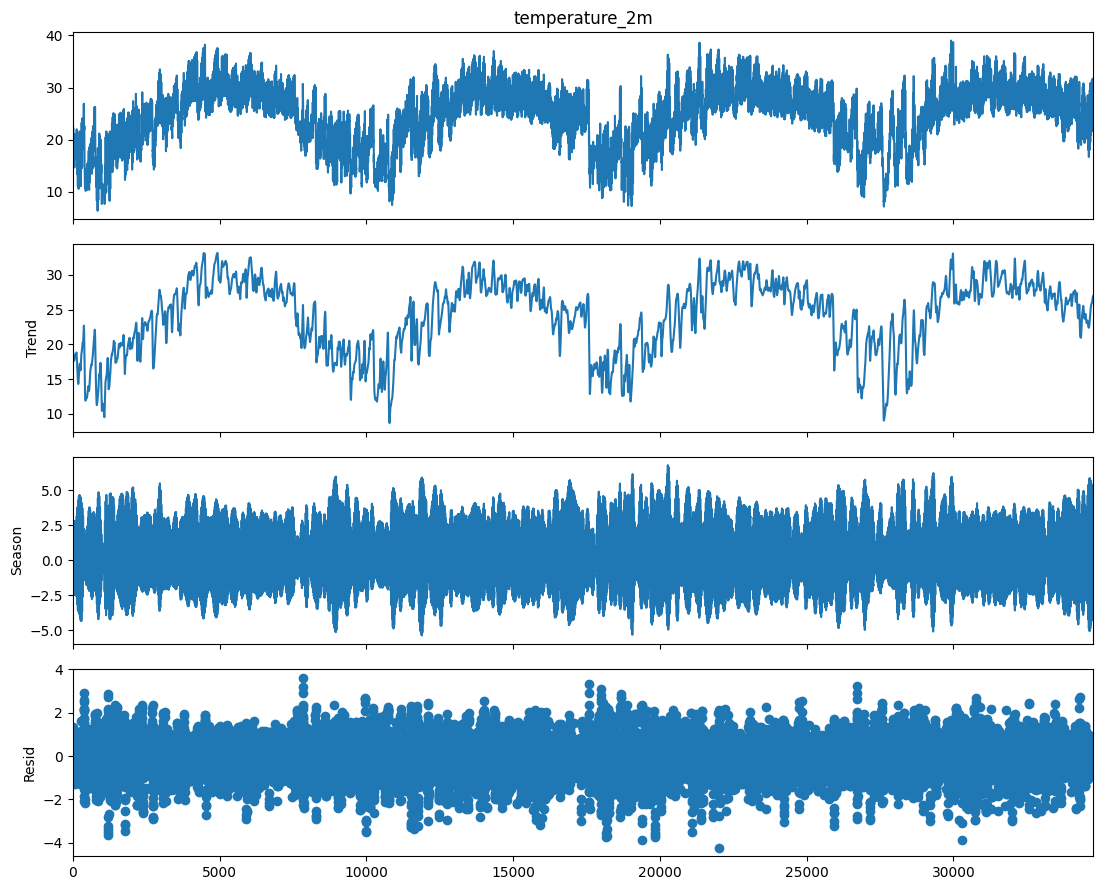

In [47]:
rcParams['figure.figsize'] = 11, 9
res = STL(df['temperature_2m'], period=24).fit()
res.plot()
plt.show()